In [2]:
import networkx as nx

num_nodes = 10
p = [1] * num_nodes

# Create an undirected graph
G = nx.Graph()
G.add_nodes_from(range(1, num_nodes+1, 1))

def max_flow(s,t):
    pass

flows = [-1, -1]
for s in range(2, num_nodes+1, 1):
    # Compute a minimum cut between nodes
    f_max, S, T = max_flow(s,t)
    flows.append(f_max)
    for i in range(1, num_nodes+1, 1):
        if s != i and i in S and p[i] == t:
            p[i] = s
    if p[t] in S:
        p[s] = p[t]
        p[t] = s
        flows[s] = flows[t]
        flows[t] = f_max

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


NameError: name 'i' is not defined

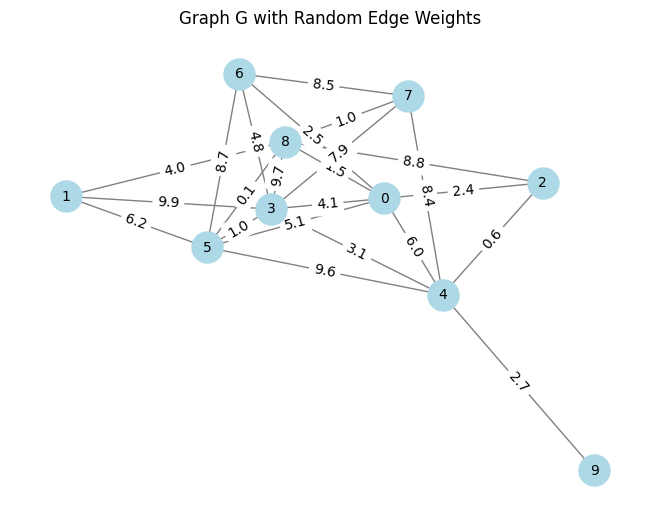

KeyboardInterrupt: 

In [14]:
import networkx as nx
from networkx.utils import not_implemented_for

from networkx.algorithms.flow.edmondskarp import edmonds_karp
from networkx.algorithms.flow.utils import build_residual_network

default_flow_func = edmonds_karp

__all__ = ["gomory_hu_tree"]

def gomory_hu_tree(G, capacity="capacity", flow_func=None):
    r"""Returns the Gomory-Hu tree of an undirected graph G.

    A Gomory-Hu tree of an undirected graph with capacities is a
    weighted tree that represents the minimum s-t cuts for all s-t
    pairs in the graph.

    It only requires `n-1` minimum cut computations instead of the
    obvious `n(n-1)/2`. The tree represents all s-t cuts as the
    minimum cut value among any pair of nodes is the minimum edge
    weight in the shortest path between the two nodes in the
    Gomory-Hu tree.

    The Gomory-Hu tree also has the property that removing the
    edge with the minimum weight in the shortest path between
    any two nodes leaves two connected components that form
    a partition of the nodes in G that defines the minimum s-t
    cut.

    See Examples section below for details.

    Parameters
    ----------
    G : NetworkX graph
        Undirected graph

    capacity : string
        Edges of the graph G are expected to have an attribute capacity
        that indicates how much flow the edge can support. If this
        attribute is not present, the edge is considered to have
        infinite capacity. Default value: 'capacity'.

    flow_func : function
        Function to perform the underlying flow computations. Default value
        :func:`edmonds_karp`. This function performs better in sparse graphs
        with right tailed degree distributions.
        :func:`shortest_augmenting_path` will perform better in denser
        graphs.

    Returns
    -------
    Tree : NetworkX graph
        A NetworkX graph representing the Gomory-Hu tree of the input graph.

    Raises
    ------
    NetworkXNotImplemented
        Raised if the input graph is directed.

    NetworkXError
        Raised if the input graph is an empty Graph.

    Examples
    --------
    >>> G = nx.karate_club_graph()
    >>> nx.set_edge_attributes(G, 1, "capacity")
    >>> T = nx.gomory_hu_tree(G)
    >>> # The value of the minimum cut between any pair
    ... # of nodes in G is the minimum edge weight in the
    ... # shortest path between the two nodes in the
    ... # Gomory-Hu tree.
    ... def minimum_edge_weight_in_shortest_path(T, u, v):
    ...     path = nx.shortest_path(T, u, v, weight="weight")
    ...     return min((T[u][v]["weight"], (u, v)) for (u, v) in zip(path, path[1:]))
    >>> u, v = 0, 33
    >>> cut_value, edge = minimum_edge_weight_in_shortest_path(T, u, v)
    >>> cut_value
    10
    >>> nx.minimum_cut_value(G, u, v)
    10
    >>> # The Gomory-Hu tree also has the property that removing the
    ... # edge with the minimum weight in the shortest path between
    ... # any two nodes leaves two connected components that form
    ... # a partition of the nodes in G that defines the minimum s-t
    ... # cut.
    ... cut_value, edge = minimum_edge_weight_in_shortest_path(T, u, v)
    >>> T.remove_edge(*edge)
    >>> U, V = list(nx.connected_components(T))
    >>> # Thus U and V form a partition that defines a minimum cut
    ... # between u and v in G. You can compute the edge cut set,
    ... # that is, the set of edges that if removed from G will
    ... # disconnect u from v in G, with this information:
    ... cutset = set()
    >>> for x, nbrs in ((n, G[n]) for n in U):
    ...     cutset.update((x, y) for y in nbrs if y in V)
    >>> # Because we have set the capacities of all edges to 1
    ... # the cutset contains ten edges
    ... len(cutset)
    10
    >>> # You can use any maximum flow algorithm for the underlying
    ... # flow computations using the argument flow_func
    ... from networkx.algorithms import flow
    >>> T = nx.gomory_hu_tree(G, flow_func=flow.boykov_kolmogorov)
    >>> cut_value, edge = minimum_edge_weight_in_shortest_path(T, u, v)
    >>> cut_value
    10
    >>> nx.minimum_cut_value(G, u, v, flow_func=flow.boykov_kolmogorov)
    10

    Notes
    -----
    This implementation is based on Gusfield approach [1]_ to compute
    Gomory-Hu trees, which does not require node contractions and has
    the same computational complexity than the original method.

    See also
    --------
    :func:`minimum_cut`
    :func:`maximum_flow`

    References
    ----------
    .. [1] Gusfield D: Very simple methods for all pairs network flow analysis.
           SIAM J Comput 19(1):143-155, 1990.

    """
    if flow_func is None:
        flow_func = default_flow_func

    if len(G) == 0:  # empty graph
        msg = "Empty Graph does not have a Gomory-Hu tree representation"
        raise nx.NetworkXError(msg)

    # Start the tree as a star graph with an arbitrary node at the center
    tree = {}
    labels = {}
    iter_nodes = iter(G)
    root = next(iter_nodes)
    for n in iter_nodes:
        tree[n] = root

    # Reuse residual network
    R = build_residual_network(G, capacity)

    # For all the leaves in the star graph tree (that is n-1 nodes).
    for source in tree:
        # Find neighbor in the tree
        target = tree[source]
        # compute minimum cut
        cut_value, partition = nx.minimum_cut(
            G, source, target, capacity=capacity, flow_func=flow_func, residual=R
        )
        labels[(source, target)] = cut_value
        # Update the tree
        # Source will always be in partition[0] and target in partition[1]
        for node in partition[0]:
            if node != source and node in tree and tree[node] == target:
                tree[node] = source
                labels[node, source] = labels.get((node, target), cut_value)
        #
        if target != root and tree[target] in partition[0]:
            labels[source, tree[target]] = labels[target, tree[target]]
            labels[target, source] = cut_value
            tree[source] = tree[target]
            tree[target] = source

    # Build the tree
    T = nx.Graph()
    T.add_nodes_from(G)
    T.add_weighted_edges_from(((u, v, labels[u, v]) for u, v in tree.items()))
    return T

# Create an undirected graph with 10 nodes and random edge weights
import random

G = nx.Graph()
num_nodes = 10

# Add nodes
G.add_nodes_from(range(num_nodes))

# Add random weighted edges
for i in range(num_nodes):
    for j in range(i + 1, num_nodes):
        if random.random() > 0.5:  # Randomly decide whether to add an edge
            weight = random.uniform(0.1, 10.0)  # Random weight between 0.1 and 10.0
            G.add_edge(i, j, capacity=weight)

import matplotlib.pyplot as plt
import networkx as nx

# Visualize the graph G
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(G, 'capacity')
# Format edge labels to show only one digit
edge_labels = {k: f"{v:.1f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("Graph G with Random Edge Weights")
plt.show()

# Compute the Gomory-Hu tree of the graph
T = gomory_hu_tree(G)

# Visualize the Gomory-Hu tree T
pos = nx.spring_layout(T)  # positions for all nodes
nx.draw(T, pos, with_labels=True, node_color='lightgreen', edge_color='black', node_size=500, font_size=10)
edge_labels = nx.get_edge_attributes(T, 'weight')
# Format edge labels to show only one digit
edge_labels = {k: f"{v:.1f}" for k, v in edge_labels.items()}
nx.draw_networkx_edge_labels(T, pos, edge_labels=edge_labels)
plt.title("Gomory-Hu Tree")
plt.show()
